<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = 'ALL'

cell_metadata_path = '/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/cell_meta.after_qc.msg'

### Not through papermill

In [5]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [6]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [7]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


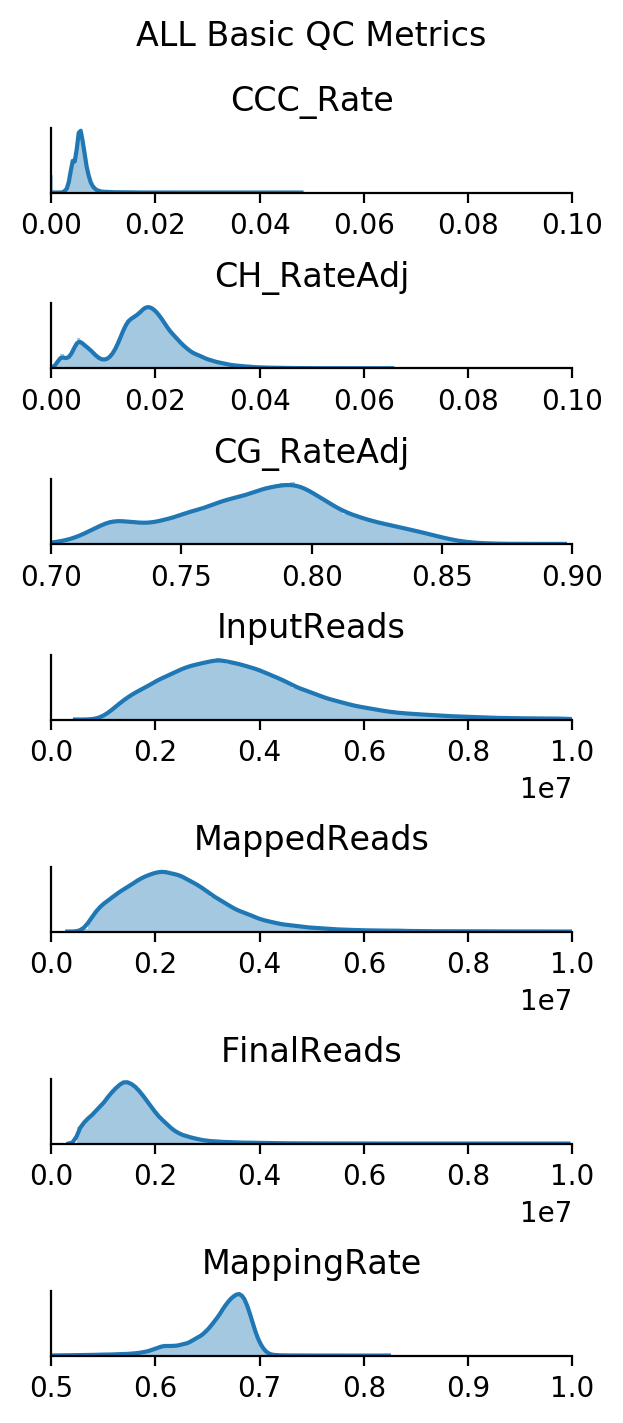

In [8]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

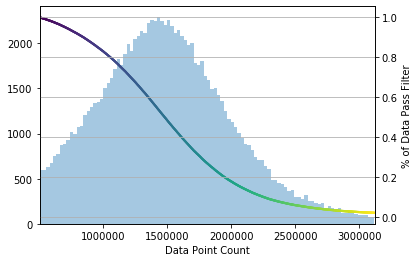

In [9]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [10]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 109670/109670 (100.0%)
CG_RateAdj passed 109670/109670 (100.0%)
CH_RateAdj passed 109670/109670 (100.0%)
FinalReads passed 109670/109670 (100.0%)
MappingRate passed 109670/109670 (100.0%)
Overall passed 109670/109670 (100.0%)


In [11]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [12]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1198
171207 1259
171212 291
171213 1243
171214 1104
171219 1430
180104 1322
180109 970
180110 1220
180111 540
180119 1428
180122 1167
180123 1394
180129 1382
180130 1285
180205 1179
180206 1288
180208 1374
180212 1256
180213 1400
180220 1437
180222 1249
180226 1363
180227 1095
180305 1036
180306 1415
180312 1334
180313 540
180319 313
180320 1337
180326 1189
180329 1339
180402 1254
180403 1600
180405 1135
180409 1151
180410 1046
180412 1114
180416 1291
180417 1038
180419 1001
180423 1237
180424 910
180426 1278
180430 1245
180501 1125
180514 848
180529 1200
180605 1136
180612 1230
180724 186
180806 715
180904 141
180910 952
180911 1213
180917 1015
180925 1361
181002 1181
181008 1307
181009 1317
181015 1388
181016 1305
181022 1325
181023 1329
181204 957
181206 1238
181210 1237
181218 758
181220 1520
190108 1328
190117 1333
190122 1286
190124 1215
190131 1229
190205 2631
190207 1241
190212 2566
190214 2642
190219 2539
190305 2603
190307 1175
190625

In [15]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/cell_meta.shape[0]*100:.1f}%')

Cells pass basic QC in each random index:
ad001 13299 12.1%
ad002 13829 12.6%
ad004 13830 12.6%
ad006 13825 12.6%
ad007 13717 12.5%
ad008 13815 12.6%
ad010 13693 12.5%
ad012 13662 12.5%


## Plateview of key metrics

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [18]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [19]:
cell_meta

,AllcPath,BamFilteringRate,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,Col384,Col96,FACS_Date,...,MappingRate,PassFilter,Plate,Pos96,Region,Row384,Row96,Slice,index_name,uid
cell,,,,,,,,,,,,,,,,,,,,,
1A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.698972,0.004240,0.766260,0.765260,0.020970,0.016800,18,9,180226,...,0.680768,True,CEMBA180226-1A-1,A10,1A,0,0,1,ad001,CEMBA180226-1A-1-CEMBA180226-1A-2-A10
1A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.695803,0.004220,0.759720,0.758700,0.020320,0.016170,18,9,180226,...,0.686971,True,CEMBA180226-1A-1,A10,1A,1,0,1,ad002,CEMBA180226-1A-1-CEMBA180226-1A-2-A10
1A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.654072,0.004260,0.777700,0.776750,0.019680,0.015490,21,10,180226,...,0.685559,True,CEMBA180226-1A-1,A11,1A,1,0,1,ad006,CEMBA180226-1A-1-CEMBA180226-1A-2-A11
1A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.628784,0.004250,0.763680,0.762670,0.018550,0.014360,20,10,180226,...,0.674022,True,CEMBA180226-1A-2,B11,1A,3,1,1,ad008,CEMBA180226-1A-1-CEMBA180226-1A-2-B11
1A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.674102,0.004300,0.778420,0.777460,0.021090,0.016860,7,3,180226,...,0.669421,True,CEMBA180226-1A-4,D4,1A,6,3,1,ad010,CEMBA180226-1A-3-CEMBA180226-1A-4-D4
1A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.676397,0.004500,0.767620,0.766570,0.022590,0.018170,7,3,180226,...,0.677259,True,CEMBA180226-1A-4,D4,1A,7,3,1,ad012,CEMBA180226-1A-3-CEMBA180226-1A-4-D4
1A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.701748,0.004990,0.780070,0.778970,0.025500,0.020610,8,4,180226,...,0.675227,True,CEMBA180226-1A-3,D5,1A,6,3,1,ad001,CEMBA180226-1A-3-CEMBA180226-1A-4-D5
1A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.707661,0.004160,0.744950,0.743880,0.019560,0.015460,8,4,180226,...,0.690117,True,CEMBA180226-1A-3,D5,1A,7,3,1,ad002,CEMBA180226-1A-3-CEMBA180226-1A-4-D5
1A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.701251,0.003510,0.757670,0.756820,0.015320,0.011850,9,4,180226,...,0.681536,True,CEMBA180226-1A-3,D5,1A,6,3,1,ad004,CEMBA180226-1A-3-CEMBA180226-1A-4-D5
